In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"13xmiSh8AgQjj6BJ7Dxu_byo59bnlUT8h"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
# Required Libraries
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
from numpy import linalg
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [65]:
dataset = pd.read_csv('data.csv',encoding="ISO-8859-1") # dataset incorporation
dataset.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


## 1. Data Preprocessing 

In [66]:
# DATA CLEANING AND PREPROCESSING STARTS HERE

# dropping the unnecessary columns from the dataset
dataset.drop(['stn_code','agency','sampling_date','location_monitoring_station'], axis=1,inplace=True)
dataset.info()# printing info
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   state     435742 non-null  object 
 1   location  435739 non-null  object 
 2   type      430349 non-null  object 
 3   so2       401096 non-null  float64
 4   no2       419509 non-null  float64
 5   rspm      395520 non-null  float64
 6   spm       198355 non-null  float64
 7   pm2_5     9314 non-null    float64
 8   date      435735 non-null  object 
dtypes: float64(5), object(4)
memory usage: 29.9+ MB


,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [0]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25) #it is middle number between smallest value and median
    q3 = df_in[col_name].quantile(0.75) #it is middle number between largest value and median
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr #any number suspected lower than this value is suspected outlier
    fence_high = q3+1.5*iqr #any number suspected higher than this value is suspected outlier
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]  # limiting the dataset values to just the range where outliers does not exists
    #return df_out
# calling function to remove outlier values from the pollutant columns of the dataset
remove_outlier(dataset,'so2')
remove_outlier(dataset,'no2')
remove_outlier(dataset,'rspm')
remove_outlier(dataset,'spm')


In [0]:
by_State=dataset.groupby('state')#grouping dataset by state

# filling the nan values with the mean of that column 

def impute_mean(series):
    return series.fillna(series.mean())

dataset['rspm'] = by_State['rspm'].transform(impute_mean)    #transforming null values in rspm column
dataset['so2'] = by_State['so2'].transform(impute_mean)      #transforming null values in so2 column
dataset['no2'] = by_State['no2'].transform(impute_mean)      #transforming null values in no2 column
dataset['spm'] = by_State['spm'].transform(impute_mean)      #transforming null values in spm column
dataset['pm2_5'] = by_State['pm2_5'].transform(impute_mean)  #transforming null values in pm25 column


In [69]:
#Missing values being filled in columns
for col in dataset.columns.values:
    if dataset[col].isnull().sum() == 0:
        continue
    if col == 'date':          # filling mean values in data point date
        guess_values = dataset.groupby('state')['date'].apply(lambda x: x.mode().max())
    elif col=='type':         #filling mean values in data point type
        guess_values = dataset.groupby('state')['type'].apply(lambda x: x.mode().max())
    else:                     #filling mean values in data point location
        guess_values = dataset.groupby('state')['location'].apply(lambda x: x.mode().max())
dataset.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,NaN,1990-03-01


### Correlation among original pollutant features
df.corr() compute pairwise correlation of columns.Correlation shows how the two variables are related to each other.Positive values shows as one variable increases other variable increases as well. Negative values shows as one variable increases other variable decreases.Bigger the values,more strongly two varibles are correlated and viceversa.

In [70]:
# Computing coorelation between pollutants
df = dataset[['so2','no2','rspm','spm']]   # independent variables matrix - pollutant concentrations
df.corr() # computing correlation

,so2,no2,rspm,spm
so2,1.000000,0.346429,0.160417,0.142689
no2,0.346429,1.000000,0.352189,0.326767
rspm,0.160417,0.352189,1.000000,0.618619
spm,0.142689,0.326767,0.618619,1.000000


Text(0.5, 1.0, 'Correlation between different fearures')

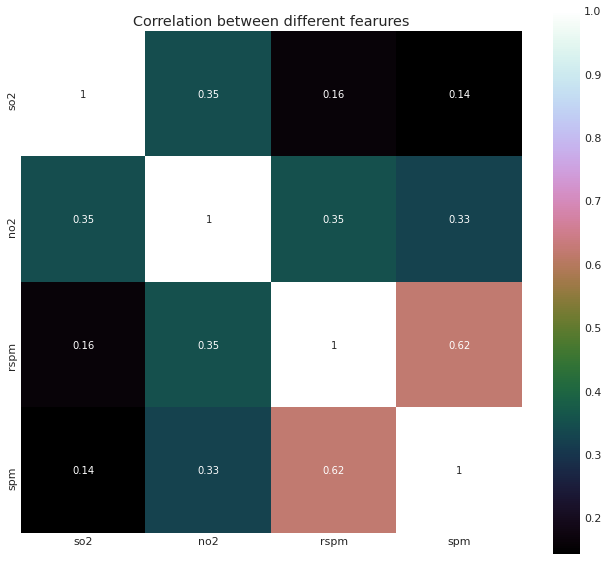

In [71]:
correlation = df.corr() # computing correlation
plt.figure(figsize=(10,10)) # plotting results
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix') 

plt.title('Correlation between different fearures')

In [72]:
# Derivation for Individual Pollutant Index and AQI STARTS HERE

# EPA METHOD FORMULA
#  AQI_{P} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SO2 pollutant by EPA method formula given above
#  SO2 is scaled between 0-1600
def calculate_si(so2):
    si=0
    if (so2<=40):
     si = so2 * (50/40)
    elif (so2>40 and so2<=80):
     si = 50 + (so2-40) * (50/(80-40))
    elif (so2>80 and so2<=380):
     si = 100 + (so2-80) * (100/(380-80))
    elif (so2>380 and so2<=800):
     si = 200 + (so2-380) * (100/(800-380))
    elif (so2>800 and so2<=1600):
     si = 300 + (so2-800) * (100/(1600-800))
    elif (so2>1600):
     si = 400 + (so2-1600) * (100/800)
    return si

# calling the function to calulate so2 pollutant index
dataset['si'] = dataset['so2'].apply(calculate_si)
df_si = dataset[['so2','si']]
df_si.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [73]:
#Function to calculate no2 individual pollutant index(ni)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of NO2 pollutant by EPA method formula given above
#  NO2 is scaled between 0-400
def calculate_ni(no2):
    ni = 0
    if(no2<=40):
     ni = no2*50/40
    elif(no2>40 and no2<=80):
     ni = 50 + (no2-40)*(50/(80-40))
    elif(no2>80 and no2<=180):
     ni = 100 + (no2-80)*(100/(180-80))
    elif(no2>180 and no2<=280):
     ni = 200 + (no2-180)*(100/(280-180))
    elif(no2>280 and no2<=400):
     ni = 300 + (no2-280)*(100/(400-280))
    else:
     ni = 400 + (no2-400)*(100/120)
    return ni

# calling the function to calulate so2 pollutant index
dataset['ni'] = dataset['no2'].apply(calculate_ni)
df_ni = dataset[['no2','ni']]
df_ni.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [74]:
#Function to calculate rspm individual pollutant index(rpi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of RSPM pollutant by EPA method formula given above
#  RSPM is scaled between 0-400
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi = rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi = 50+(rpi-30)*50/(60-30)
    elif(rpi>60 and rpi<=90):
     rpi = 100+(rpi-60)*100/(90-60)
    elif(rpi>90 and rpi<=120):
     rpi = 200+(rpi-90)*100/(120-90)
    elif(rpi>120 and rpi<=250):
     rpi = 300+(rpi-120)*(100/(250-120))
    else:
     rpi = 400+(rpi-250)*(100/130)
    return rpi

# calling the function to calulate RSPM pollutant index
dataset['rpi']=dataset['rspm'].apply(calculate_si)
df_rpi = dataset[['rspm','rpi']]
df_rpi.head()


,rspm,rpi
0,78.182824,97.72853
1,78.182824,97.72853
2,78.182824,97.72853
3,78.182824,97.72853
4,78.182824,97.72853


In [75]:
#Function to calculate spm individual pollutant index(spi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SPM pollutant by EPA method formula given above
#  SPM is scaled between 0-400
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi = spm*50/50
    elif(spm>50 and spm<=100):
     spi = 50 + (spm-50)*(50/(100-50))
    elif(spm>100 and spm<=250):
     spi = 100 + (spm-100)*(100/(250-100))
    elif(spm>250 and spm<=350):
     spi=200 + (spm-250)*(100/(350-250))
    elif(spm>350 and spm<=430):
     spi=300 + (spm-350)*(100/(430-350))
    else:
     spi=400+(spm-430)*(100/430)
    return spi

# calling the function to calulate SPM pollutant index
dataset['spi'] = dataset['spm'].apply(calculate_spi)
df_spm = dataset[['spm','spi']]
df_spm.head()

,spm,spi
0,200.260378,166.840252
1,200.260378,166.840252
2,200.260378,166.840252
3,200.260378,166.840252
4,200.260378,166.840252


In [76]:
#function to calculate the air quality index (AQI) of every data value its is calculated as per indian govt standards

# AQI = MAX ( AQI_{SO2}, AQI_{NO2}, AQI_{RSPM}, AQI_{SPM})
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi

# calling the function to calulate AQI 
dataset['AQI'] = dataset.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df= dataset[['state','si','ni','rpi','spi','AQI']]
df.head()

,state,si,ni,rpi,spi,AQI
0,Andhra Pradesh,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,5.875,9.375,97.72853,166.840252,166.840252


In [0]:
# filling 0 in the place of NAN values
dataset.fillna(0.0, inplace=True)
state=dataset.groupby(['state'],as_index=False).mean()  # calulating mean of the pollutant concentration for each state

Computing Correlation among the features in the dataset

In [78]:
# Computing coorelation between pollutants
df1 = dataset[['si','ni','rpi','spi']]   # independent variables matrix - pollutant concentrations
df1.corr()

,si,ni,rpi,spi
si,1.000000,0.383492,0.215005,0.158088
ni,0.383492,1.000000,0.360968,0.328635
rpi,0.215005,0.360968,1.000000,0.613163
spi,0.158088,0.328635,0.613163,1.000000


Text(0.5, 1.0, 'Correlation between pollutant index of each of the pollutants')

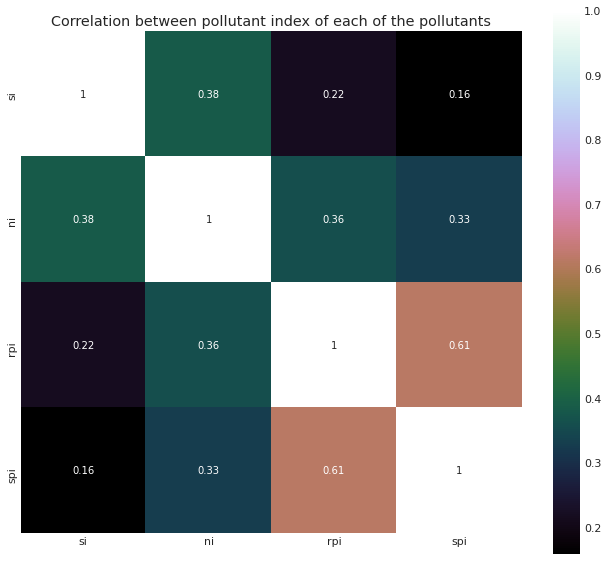

In [79]:
correlation = df1.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

plt.title('Correlation between pollutant index of each of the pollutants')

# 2 PCA Analysis

## 2.1 Functions for computing PCA
### 2.1.1 Normalize Function

In [0]:
# Normalize Function
def normalize(X):
  """Normalize the given dataset X
  Args:
  X: ndarray, dataset

  Returns:
  (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
  with mean 0 and standard deviation 1; mean and std are the
  mean and standard deviation respectively.

  Note:
  You will encounter dimensions where the standard deviation is
  zero, for those when you do normalization the normalized data
  will be NaN. Handle this by setting using `std = 1` for those
  dimensions when doing normalization.
  """
  mu = np.mean(X, axis=0) #mean
  std = np.std(X, axis=0) #standard deviation
  new_std = np.where(std>0,std,1) #new standard deviation
  a = np.subtract(X,mu) # a = x- mean
  Xbar = np.divide(a,new_std) # Xbar = a/new standard deviation
  return Xbar, mu, std

### 2.1.2 Eig Function 
Computes Eigen Values and Eigen Vectors of Covariance Matrix S

In [0]:
def eig(S):
  """Compute the eigenvalues and corresponding eigenvectors
  for the covariance matrix S.
  Args:
  S: ndarray, covariance matrix
  Returns:
  (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors
  Note:
  the eigenvals and eigenvecs should be sorted in descending
  order of the eigen values
  """
  eigvals, eigvecs = np.linalg.eig(S) # computing eigen values and eigen vectors of our feature matrix
  idx = eigvals.argsort()[::-1]       # sorting values in descending order
  eigvals = eigvals[idx]              # replacing by sorted array
  eigvecs = eigvecs[:,idx]            # replacing by sorted array

  return (eigvals, eigvecs) 

### 2.1.3 Projection Matrix Function

In [0]:
def projection_matrix(B):
  """Compute the projection matrix onto the space spanned by `B`
  Args:
  B: ndarray of dimension (D, M), the basis for the subspace

  Returns:
  P: the projection matrix
  """
  P = np.matmul(B,B.T) # P = B*B.T (projection Matrix)
  return P


### 2.1.4 PCA Function
Takes X (input matrix) and M (number of components) as input and Computes Reconstructed X (input) matrix by appling Principal Component Analysis (PCA) 

In [0]:
def PCA(X, num_components):
  """
  Args:
  X: ndarray of size (N, D), where D is the dimension of the data,
  and N is the number of datapoints
  num_components: the number of principal components to use.
  Returns:
  X_reconstruct: ndarray of the reconstruction
  of X from the first `num_components` principal components.
  """
  Xbar, mu, std = normalize(X) # normalizing data
  covariance = np.dot(Xbar.T,Xbar) # computing covariancematrix
  S = covariance # S is denoted as our covariance matrix
  eigvals, eigvecs = eig(S) # eigvals = eigen values and eigvecs = eigen vectors

  sum_value = sum(eigvals[:num_components]) # sum of M (num_components) eigen values (principal components)
  B = np.stack(eigvecs[:,:num_components]) # taking first M (num_components) principal components to form matrix B
  P = np.matmul(B,B.T) # calculating P (projection matrix)  for  B
  X_reconstruct = np.matmul(P,X.T) # reconstructing X
  X_reconstruct = X_reconstruct.T # transposing reconstructed X
  return X_reconstruct, sum_value 


## 2.2 Analysis of PCA for a particular value of M (say M=2)

### 2.2.1 Defining Input Matrix 

In [84]:
# Computing input matrix X having four features and 435742 rows
X = dataset[['si','ni','rpi','spi']]   # independent variables matrix - pollutant concentrations
y = dataset['AQI']                     # target variable matrix - AQI

print('The dimension of input matrix X is: ', X.shape)   # print shape of input matrix X
print(X)


The dimension of input matrix X is:  (435742, 4)
            si      ni         rpi         spi
0        6.000  21.750   97.728530  166.840252
1        3.875   8.750   97.728530  166.840252
2        7.750  35.625   97.728530  166.840252
3        7.875  18.375   97.728530  166.840252
4        5.875   9.375   97.728530  166.840252
...        ...     ...         ...         ...
435737  27.500  62.500  121.000000  189.004349
435738  25.000  57.500  130.333333  189.004349
435739   0.000   0.000    0.000000    0.000000
435740   0.000   0.000    0.000000    0.000000
435741   0.000   0.000    0.000000    0.000000

[435742 rows x 4 columns]


### 2.2.2 Normalizing the Dataset
Normalization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance). It is useful to standardize attributes for a model. Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data


In [85]:
## Some preprocessing of the data
Xbar, mu, std = normalize(X)          # Normalizing input matrix X
print('The dimension of normalized input matrix X is: ', Xbar.shape)    # print shape of normalized X (Xbar)
print('The dimension of mean of input matrix X is: ', mu.shape)          # print shape of mean of X
print('The dimension of standard deviation of input matrix X is: ', X.shape)  # print shape of standard deviation of X

The dimension of normalized input matrix X is:  (435742, 4)
The dimension of mean of input matrix X is:  (4,)
The dimension of standard deviation of input matrix X is:  (435742, 4)


### 2.2.3 Finding the Covariance Matrix

In [86]:
# Finding Covariance matrix
covariance = np.dot(Xbar.T,Xbar)
print('Shape of covariance matrix : ', covariance.shape)        # print shape of covariance matrix 
print('Trace of covariance matrix : ', np.trace(covariance))    # print trace of convariance matrix

print()
S = covariance
eigvals, eigvecs = eig(S)      # find eigen values and eigen vectors in sorted order (decreasing) of covariance matrix
     

Shape of covariance matrix :  (4, 4)
Trace of covariance matrix :  1742968.0000001471



### 2.2.4 Variance of each principal components/features
**Explained Variance** 
After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

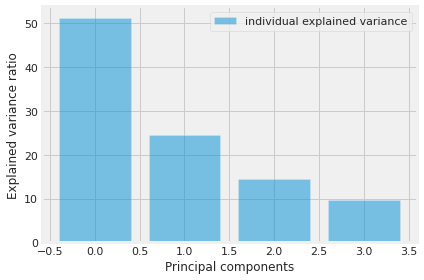

In [87]:
tot = sum(eigvals) # sum of all eigenvalues
var_exp = [(i / tot)*100 for i in eigvals] # computing explained variance- variance contributed to each of the principal components (in %)

plt.figure(figsize=(6, 4)) # mentioning size of the bar graph

#plotiing bar graph
plt.bar(range(4), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

The above plot above clearly shows that maximum variance (somewhere around 50%) can be explained by the first principal component alone. The second principal component shows variance of about 25%, and Comparatively third and fourth components share less amount of information as compared to the rest of the Principal components. Hence, for analysis we take M = 2 (number of principal components to be considered for low dimenional data) as they have much more variance than the last two principal components.



In [88]:
num_components = 2                          # taking random value of M for analysis
print('Eigen values sorted in decreasing order:')  # printing eigenvalues in decreasing order
for i in eigvals: 
    print(i)
print()
print('Top M (where M=2) Eigenvalues : ', eigvals[:num_components])             # printing top M eigenvalues
print()
print('M eigenvectors correspondong to top M eigenvalues: \n', eigvecs[:,:num_components])  # printing top M eigenvectors corresponding to top M eigenvalues

print()
print('Shape of one eigenvector : ', eigvecs.shape[0])    # printing eigenvector shape

Eigen values sorted in decreasing order:
894576.6285090947
428403.7878513784
252699.9521340202
167287.6315056542

Top M (where M=2) Eigenvalues :  [894576.62850909 428403.78785138]

M eigenvectors correspondong to top M eigenvalues: 
 [[ 0.37771276  0.72301441]
 [ 0.49901073  0.36349529]
 [ 0.56268523 -0.36866975]
 [ 0.54009878 -0.45738818]]

Shape of one eigenvector :  4


### 2.2.5 Plotting sorted eigenvalues in decreasing order

     eigenvalues
0  894576.628509
1  428403.787851
2  252699.952134
3  167287.631506


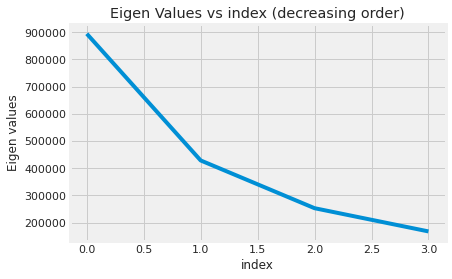

In [89]:
# Plotting sorted eigen values (in decreasing order) v/s its index 
eigvals = np.asarray(eigvals)      # converting to array
eig_df = pd.DataFrame(eigvals)     # making a dataframe with index and eigenvalues
eig_df.rename(columns={0 : 'eigenvalues'},  inplace = True)  #renaming the column of dataframe to eigenvalues
print(eig_df.head())        # printing all the eigenvalues ( 1 to D (total number of features i.e. 4))

fig, ax = plt.subplots()
ax.plot(eigvals);
ax.set(xlabel='index', ylabel='Eigen values', title='Eigen Values vs index (decreasing order)');

### 2.2.6 Calculating Projection Matrix and calling PCA function

In [90]:
## Calculation of Projection matrix and Reconstructed X matrix
B = np.stack(eigvecs[:,:num_components])   
print('Shape of matrix B (top M eigenvectors (M=2 in this case)) : ', B.shape)
print('Trace of matrix B : ', np.trace(B))  

print()
P = projection_matrix(B)  # finding projection matrix P
print('Shape of Projection matrix : ', P.shape)

print()
X_reconstruct, sum_value = PCA(Xbar, num_components)            # finding reconstructed X by selecting num_components principal components
print('Shape of X_reconstruct matrix : ', X_reconstruct.shape)  # printing shape of X_reconstruct matrix
print('Shape of normalized X matrix : ', Xbar.shape)            # printing shape of normalized X matrix

print()
print('X reconstruced : \n', X_reconstruct)                     # printing projected data matrix (reconstructed X)

Shape of matrix B (top M eigenvectors (M=2 in this case)) :  (4, 2)
Trace of matrix B :  0.7412080533513133

Shape of Projection matrix :  (4, 4)

Shape of X_reconstruct matrix :  (435742, 4)
Shape of normalized X matrix :  (435742, 4)

X reconstruced : 
               si        ni       rpi       spi
0      -0.580874 -0.465445 -0.127513 -0.069566
1      -0.964828 -0.770251 -0.204838 -0.108370
2      -0.199599 -0.159465 -0.042668 -0.022720
3      -0.546948 -0.453963 -0.158435 -0.105079
4      -0.841879 -0.684731 -0.209604 -0.126399
...          ...       ...       ...       ...
435737  1.374532  1.163031  0.452352  0.319969
435738  1.120329  1.020688  0.546439  0.444131
435739 -0.982780 -1.648900 -2.320495 -2.288670
435740 -0.982780 -1.648900 -2.320495 -2.288670
435741 -0.982780 -1.648900 -2.320495 -2.288670

[435742 rows x 4 columns]


In [91]:
## Calculation of unnormalized X reconstructed matrix
mu = np.mean(X, axis=0)   # finding mean of input matrix X
std = np.std(X, axis=0)   # finding standard deviation of input matrix X
X_final = X_reconstruct * std + mu   # unnomalizing X reconstruct to X_final 
print('Shape of unnormalized reconstructed matrix : ', X_reconstruct.shape)  # printing shape of unnormalized reconstructed matrix
print('Shape of input matrix X : ', Xbar.shape)      # printing shape of input matrix X matrix

Shape of unnormalized reconstructed matrix :  (435742, 4)
Shape of input matrix X :  (435742, 4)


### 2.2.7 Comparison of our PCA function with sklearn library

In [92]:
# Comparison user functions with inbuilt Library
from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler(with_mean=True, with_std=True)
sample_data = standardized_data.fit_transform(Xbar)    # normalizing the dataset using library

print('Shape of Normalized input matrix computed using library : ' , sample_data.shape)
print('Shape of Normalized input matrix computed using user functions : ' , Xbar.shape)

# Find the co-variance matrix which is : A^T * A

# matrix multiplication using numpy
covar_matrix = np.matmul(sample_data.T, sample_data)  # finding covariance matrix using normalized X (using inbuilt library)
print()
print("Shape of covariance matrix computed using Library = ", covar_matrix.shape)
print("Shape of covariance matrix computed by user functions = ", S.shape)

print()
print('The covariance matrix is : \n' ,covar_matrix)
print()
print('The trace of covariance matrix : ', np.trace(covar_matrix))

Shape of Normalized input matrix computed using library :  (435742, 4)
Shape of Normalized input matrix computed using user functions :  (435742, 4)

Shape of covariance matrix computed using Library =  (4, 4)
Shape of covariance matrix computed by user functions =  (4, 4)

The covariance matrix is : 
 [[435742.         167103.51206591  93686.88467662  68885.58764466]
 [167103.51206591 435742.         157288.71880688 143200.16261006]
 [ 93686.88467662 157288.71880688 435742.         267180.71513081]
 [ 68885.58764466 143200.16261006 267180.71513081 435742.        ]]

The trace of covariance matrix :  1742968.0000000023


### 2.2.8 Comparison of Actual AQI and Reconstructed AQI formed from projected data matrix X_tilda

In [93]:
# Computing Reconstructed AQI from unnormalized reconstructed X matrix
dataset['AQI_reconstructed'] = X_final.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)

# Making Reconstruced Columns for all the pollutants
dataset['ni_reconstructed'] =  X_final['ni'] # Making Reconstruced Columns for no2 
dataset['si_reconstructed'] =  X_final['si'] # Making Reconstruced Columns for so2
dataset['rpi_reconstructed'] =  X_final['rpi'] # Making Reconstruced Columns for rspm
dataset['spi_reconstructed'] =  X_final['spi'] # Making Reconstruced Columns for spm

# Defining a dataframe consisting of Actual AQI and pollutant values and Reconstructed AQI and pollutant values
df = dataset[['state','si','ni','spi','rpi','si_reconstructed','ni_reconstructed','rpi_reconstructed','spi_reconstructed','AQI','AQI_reconstructed']]
df

,state,si,ni,spi,rpi,si_reconstructed,ni_reconstructed,rpi_reconstructed,spi_reconstructed,AQI,AQI_reconstructed
0,Andhra Pradesh,6.000,21.750,166.840252,97.728530,6.117200,21.731572,94.545145,174.691802,166.840252,174.691802
1,Andhra Pradesh,3.875,8.750,166.840252,97.728530,1.476775,15.032918,91.737112,171.120923,166.840252,171.120923
2,Andhra Pradesh,7.750,35.625,166.840252,97.728530,10.725256,28.455989,97.626264,179.002764,166.840252,179.002764
3,Andhra Pradesh,7.875,18.375,166.840252,97.728530,6.527229,21.983893,93.422250,171.423756,166.840252,171.423756
4,Andhra Pradesh,5.875,9.375,166.840252,97.728530,2.962724,16.912380,91.564067,169.461780,166.840252,169.461780
...,...,...,...,...,...,...,...,...,...,...,...
435737,West Bengal,27.500,62.500,189.004349,121.000000,29.750043,57.520118,115.602690,210.538486,189.004349,210.538486
435738,West Bengal,25.000,57.500,189.004349,130.333333,26.677773,54.391893,119.019435,221.964401,189.004349,221.964401
435739,andaman-and-nicobar-islands,0.000,0.000,0.000000,0.000000,1.259806,-4.276904,14.907951,-29.519763,0.000000,14.907951
435740,Lakshadweep,0.000,0.000,0.000000,0.000000,1.259806,-4.276904,14.907951,-29.519763,0.000000,14.907951


Index    Error (AQI recosntructed & Actual)
 0          7.851550
1          4.280671
2         12.162512
3          4.583504
4          2.621528
            ...    
435737    21.534137
435738    32.960052
435739    14.907951
435740    14.907951
435741    14.907951
Length: 435742, dtype: float64

Total Error in AQI recosntructed and Actural AQI if taken 2 major principal components:  38.133229667173914



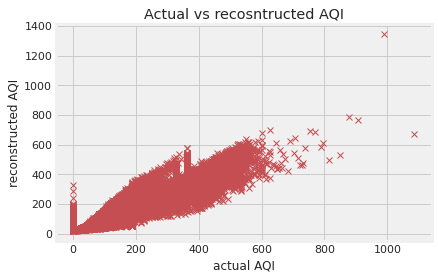

In [94]:
reconstructed = df['AQI_reconstructed'] #fetching reconstructed data
actual = df['AQI'] # fetching actual data
aqi_reconstruct_error = np.sqrt(np.square(reconstructed - actual).sum()/len(actual)) # calculating error between projected data matrix and original feature matrux 

print('Index    Error (AQI recosntructed & Actual)\n', (reconstructed - actual))
print()
print('Total Error in AQI recosntructed and Actural AQI if taken 2 major principal components: ' , aqi_reconstruct_error)
print()
fig, ax = plt.subplots() #plotting results
ax.plot(actual, reconstructed, 'rx');
#ax.xaxis.set_ticks(np.arange(1, 5, 5));
ax.set(xlabel='actual AQI', ylabel='reconstructed AQI', title='Actual vs recosntructed AQI');

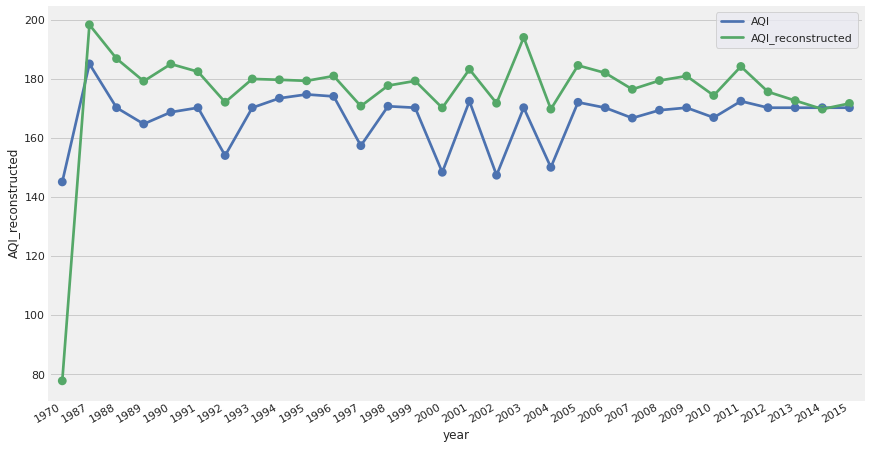

In [95]:
dataset['date'] = pd.to_datetime(dataset['date'],format='%Y-%m-%d') # transforming the date column into '%Y-%m-%d' formate 
dataset['year'] = dataset['date'].dt.year                           # extracting year from the date column
dataset['year'] = dataset['year'].fillna(0.0).astype(int)           # filling nan values as 0
dataset = dataset[(dataset['year']>0)]                              # extracting only non null values

df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False) #processing fetched data by grouping on year 
df1 = dataset[['AQI_reconstructed','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False) # processing fetched data by grouping on year 
f,ax=plt.subplots(figsize=(13,8))
sns.set()
ax = sns.pointplot(x='year', y='AQI', data=df, label="Actual", color='b', linestyle="-", errwidth=0.1) #plotting calculated value
ax = sns.pointplot(x='year', y='AQI_reconstructed', data=df1, color='g', label="predicted", linestyle="-", errwidth=0.1) # plotting predicted value

# plotting graph
ax.legend(handles=ax.lines[::len(df)+1], labels=["AQI","AQI_reconstructed"])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])
plt.gcf().autofmt_xdate()
plt.show()

### 2.2.9 Analysis after taking each value of the number of principal component

In [96]:
for num_component in range(1, 4):
  from sklearn.decomposition import PCA as SKPCA
  
  # Standard solution given by scikit-learn's implementation of PCA
  pca = SKPCA(n_components=num_component, svd_solver='full')
  sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))

  # Our method
  reconst, sum_value = PCA(Xbar, num_component) #analysis after taking significant components
  np.testing.assert_almost_equal(reconst, sklearn_reconst) # assserting the equality between the projected data matrix computed by own method and the inbuilt library
  print('Error between reconstructions with sklearn library and our method for each feature : \n', np.square(reconst - sklearn_reconst).sum())
  print('Shape of reconstructed matrix : ', reconst.shape)
  print()

Error between reconstructions with sklearn library and our method for each feature : 
 si     5.870280e-19
ni     5.376384e-19
rpi    2.739782e-19
spi    1.495493e-18
dtype: float64
Shape of reconstructed matrix :  (435742, 4)

Error between reconstructions with sklearn library and our method for each feature : 
 si     1.705401e-19
ni     1.412290e-19
rpi    4.797569e-19
spi    6.479692e-19
dtype: float64
Shape of reconstructed matrix :  (435742, 4)

Error between reconstructions with sklearn library and our method for each feature : 
 si     7.065350e-21
ni     1.756222e-20
rpi    5.867141e-19
spi    5.586575e-19
dtype: float64
Shape of reconstructed matrix :  (435742, 4)



### 2.2.10 Computing loss and variance for every value of M (number of principal components)

In [0]:
def mse(predict, actual):
  """Helper function for computing the mean squared error (MSE)"""
  return np.square(predict - actual).sum(axis=1).mean()     # returning mse error

In [98]:
# defining loss, reconstructions, variance_values vector
loss = []
reconstructions = []
variance_values = []

X = dataset[['rpi','spi','si','ni']]   # independent variables matrix - pollutant concentrations
Xbar, mu, std = normalize(X)

print('Taking different values of number of components from M=1 to 4 (total number of features available): ')
# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 5):
  reconst, sum_value = PCA(Xbar, num_component) #reconst contains reconstructed Xbar, sum value contains summation of significant of num_component
  error = mse(reconst, Xbar)  # computing mse error between projected data matrix and original normalized matrix 
  reconst = reconst*std + mu # un-normalizing the data
  reconstructions.append(reconst) # appending un-normalized data
  print('M = {:d}, reconstruction_error = {:f}'.format(num_component, error))
  loss.append((num_component, error)) #appending loss terms
  variance_values.append((num_component, sum_value)) # appending variance

Taking different values of number of components from M=1 to 4 (total number of features available): 
M = 1, reconstruction_error = 1.947004
M = 2, reconstruction_error = 0.963845
M = 3, reconstruction_error = 0.383914
M = 4, reconstruction_error = 0.000000


   num_components      Variance
0             1.0  8.945766e+05
1             2.0  1.322980e+06
2             3.0  1.575680e+06
3             4.0  1.742968e+06


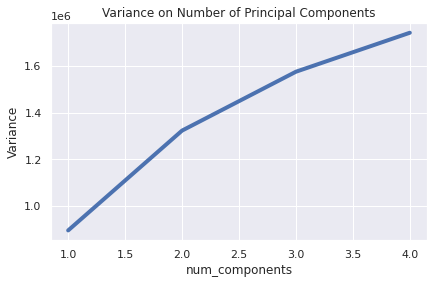

In [99]:
variance_values = np.asarray(variance_values) # converting variance into variance array
var_df = pd.DataFrame(variance_values) #converting variance into a data frame 
var_df.rename(columns={0 : 'num_components', 1: 'Variance'},  inplace = True)  # renaming the columns of dataframe 
print(var_df.head())  # printing the varaince values corresponding to all the principal components

# plotting variance plot wrt the number of principal components
sns.set()
fig, ax = plt.subplots()
ax.plot(variance_values[:,0], variance_values[:,1]); 
ax.set(xlabel='num_components', ylabel='Variance', title='Variance on Number of Principal Components');

for l in ax.lines:
    plt.setp(l,linewidth=4)

   num_components           MSE
0             1.0  1.947004e+00
1             2.0  9.638446e-01
2             3.0  3.839144e-01
3             4.0  8.792642e-31


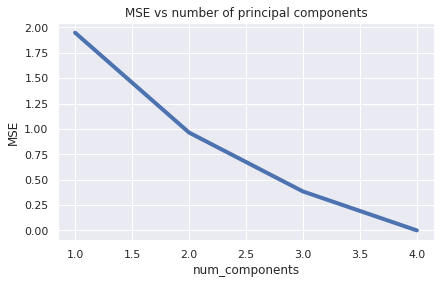

In [100]:
loss = np.asarray(loss) #converting loss value in array
loss_df = pd.DataFrame(loss) #converting loss into a data frame
loss_df.rename(columns={0 : 'num_components', 1: 'MSE'},  inplace = True)  #renaming the column of dataframe to MSE
print(loss_df) # printing the loss values corresponding to all the principal components

# plotting variance plot wrt the number of principal components
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

for l in ax.lines:
    plt.setp(l,linewidth=4)

### 2.2.10 Analysis of MSE error with respect to number of principal components with non sorted eigenvalues

In [0]:
def PCA_unsorted(X, num_components):
  """
  Args:
  X: ndarray of size (N, D), where D is the dimension of the data,
  and N is the number of datapoints
  num_components: the number of principal components to use.
  Returns:
  X_reconstruct: ndarray of the reconstruction
  of X from the first `num_components` principal components.
  """
  # your solution should take advantage of the functions you have implemented above.
  # this function is not calculating most significant eigenvalues because we want to use this for comparision with the earlier one
  Xbar, mu, std = normalize(X) #normalized data
  covariance = np.dot(Xbar.T,Xbar) # covariance = xbar*xbartrnaspose
  S = covariance # s is covariance
  eigvals, eigvecs = np.linalg.eig(S) # calculating eigen values and eigen vectors (unordered)
  sum_value = sum(eigvals[:num_components])#sum of M eigen values, we have NOT TAKEN SORTED LIST
  B = np.stack(eigvecs[:,:num_components]) # calculating matrix B by taking summation of num_components
  P = np.matmul(B,B.T) #P = B * Btranspose (projection matrix)
  X_reconstruct = np.matmul(P,X.T) #reconstructing matrix X (project data matrix)
  X_reconstruct = X_reconstruct.T
  return X_reconstruct, sum_value, eigvals 


In [104]:
# defining loss, reconstructions, variance_values vector
# defining loss FOR UNSORTED DATA
loss_unsorted = []
reconstructions_unsorted = []
variance_values_unsorted = []

X1 = dataset[['rpi','spi','si','ni']]   # independent variables matrix - pollutant concentrations
Xbar1, mu1, std1 = normalize(X1)
print('Taking different values of number of components from M=1 to 4 (total number of features available): ')
# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 5):
  reconst, sum_value, eigvals = PCA_unsorted(Xbar1, num_component)  #reconst contains reconstructed Xbar, sum value contains summation of significant of num_component
  error = mse(reconst, Xbar1)
  reconst = reconst*std1 + mu1 #reconst is un-normalized data
  reconstructions_unsorted.append(reconst) # appending un-normalized data
  print('M = {:d}, reconstruction_error = {:f}'.format(num_component, error))
  loss_unsorted.append((num_component, error)) # loss for unsorted un normalized data
  variance_values_unsorted.append((num_component, sum_value)) # variance for unsorted un normalized data

print('\nEigvalues in descending order: ')
for i in eigvals:
    print(i)

Taking different values of number of components from M=1 to 4 (total number of features available): 
M = 1, reconstruction_error = 1.947004
M = 2, reconstruction_error = 0.963845
M = 3, reconstruction_error = 0.579930
M = 4, reconstruction_error = 0.000000

Eigvalues in descending order: 
894576.6285083746
428403.78785121365
167287.63150541615
252699.95213404184


   num_components           MSE
0             1.0  1.947004e+00
1             2.0  9.638446e-01
2             3.0  5.799302e-01
3             4.0  8.810203e-31


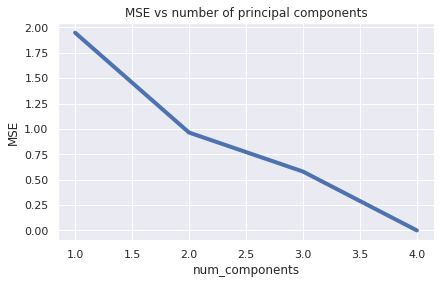

In [105]:
loss_unsorted = np.asarray(loss_unsorted) # converting loss to array
loss_df = pd.DataFrame(loss_unsorted) # as a dataframe
loss_df.rename(columns={0 : 'num_components', 1: 'MSE'},  inplace = True)  #renaming the column of dataframe
print(loss_df)

# plotting MSE vs number of principal components
fig, ax = plt.subplots()
ax.plot(loss_unsorted[:,0], loss_unsorted[:,1]);
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

for l in ax.lines:
    plt.setp(l,linewidth=4)